In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image

## STEP 1: Organize into folders (run once only)

In [3]:
# Set paths
base_dir = "dogs-vs-cats"
train_dir = os.path.join(base_dir, "train", "train")

# STEP 1: Organize into folders (run once only)
cat_dir = os.path.join(base_dir, "dataset", "train", "cat")
dog_dir = os.path.join(base_dir, "dataset", "train", "dog")
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

for fname in os.listdir(train_dir):
    if fname.startswith("cat"):
        os.rename(os.path.join(train_dir, fname), os.path.join(cat_dir, fname))
    elif fname.startswith("dog"):
        os.rename(os.path.join(train_dir, fname), os.path.join(dog_dir, fname))

## STEP 2: Transforms

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## STEP 3: Load dataset

In [5]:
data_path = os.path.join(base_dir, "dataset", "train")
full_dataset = datasets.ImageFolder(data_path, transform=transform)

## STEP 4: Split into train/val

In [6]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

## STEP 5: Load pretrained ResNet-101

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet101(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, 2)
model.to(device)

C:\Users\Deepak\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Deepak\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Deepak/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth


100%|███████████████████████████████████████████████████████████████████████████████| 171M/171M [00:23<00:00, 7.52MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## STEP 6: Train model

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

model.train()
for epoch in range(1):  # Change to more epochs for better results
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.0767


## STEP 7: Evaluate

In [9]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 98.42%


## STEP 8: Predict and Display 4 Images

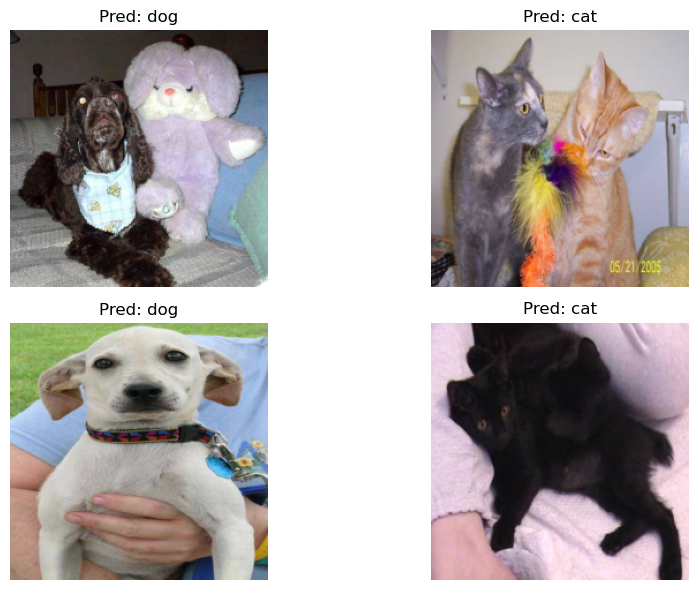

In [12]:
import random
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

classes = full_dataset.classes  # ['cat', 'dog']
plt.figure(figsize=(10, 6))
for i in range(4):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = img.clip(0, 1)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[preds[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
